# EDA & Modeling

In [1]:
random_state = 42

## Package loading

In [2]:
from modules.ezs_func import *
from modules.ezs_model import *
import numpy as np
import pandas as pd
import os
import gc
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import re
import math
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.neighbors import LocalOutlierFactor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.inspection import permutation_importance
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import WhiteKernel
from sklearn.gaussian_process.kernels import ConstantKernel
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process.kernels import RationalQuadratic
from sklearn.gaussian_process.kernels import ExpSineSquared
from sklearn.gaussian_process.kernels import DotProduct
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import set_config
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from pandas.api.types import is_numeric_dtype
from itertools import product
from joblib import dump
from scipy import stats
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer


## Project name

In [3]:
name = 'ads'

# Exploratory Data Analysis 

## Thresholds & other parameters

In [4]:
problem_type = 'regression'

In [5]:
data_size = 'small'

In [6]:
threshold_NaN = 0.5

In [7]:
threshold_cat = 5

In [8]:
threshold_Z = 3.0

In [9]:
test_size = 0.33

In [10]:
threshold_entropy = 0.75

In [11]:
undersampling = False

In [12]:
undersampler = 'Random'

In [13]:
threshold_corr = 1.0

In [14]:
threshold_model = 5

In [15]:
threshold_score = 0.7

In [16]:
threshold_feature = 5

In [17]:
with_keras = False

In [18]:
CPU = False

In [19]:
time_dep = True

In [20]:
date_idx = 0

In [21]:
lag_number = 13

In [22]:
level_1_model = 'regression'

## File & target

In [23]:
path = '/home/fifi/Documents/ezstacking/dataset/ads.csv'

In [24]:
df = pd.read_csv(path, index_col = date_idx, parse_dates = True)

In [25]:
target_col = 'Ads'

### Deployment

In [26]:
FastAPI_port = 8000

In [27]:
Docker_port = 80

# Drop user's columns & Duplicates:

In [28]:
user_drop_cols = []

Dataset before deletion

In [29]:
display(df)

Ads
Time                       
2017-09-13 00:00:00   80115
2017-09-13 01:00:00   79885
2017-09-13 02:00:00   89325
2017-09-13 03:00:00  101930
2017-09-13 04:00:00  121630
...                     ...
2017-09-21 19:00:00  155890
2017-09-21 20:00:00  123395
2017-09-21 21:00:00  103080
2017-09-21 22:00:00   95155
2017-09-21 23:00:00   80285

[216 rows x 1 columns]

In [30]:
df = df.drop(user_drop_cols, axis=1)

In [31]:
dropped_cols = user_drop_cols

Duplicate rows:

In [32]:
df = duplicates(df)

Number of rows before removing: 216
Number of duplicate rows: 4
Number of rows after removing: 212


Dataset after deletion of user’s columns and duplicates

In [33]:
display(df)

Ads
Time                       
2017-09-13 00:00:00   80115
2017-09-13 01:00:00   79885
2017-09-13 02:00:00   89325
2017-09-13 03:00:00  101930
2017-09-13 04:00:00  121630
...                     ...
2017-09-21 19:00:00  155890
2017-09-21 20:00:00  123395
2017-09-21 21:00:00  103080
2017-09-21 22:00:00   95155
2017-09-21 23:00:00   80285

[212 rows x 1 columns]

### Dataset copy

In [34]:
df_copy = df.copy()

# Dataset Information

### Dataframe structure

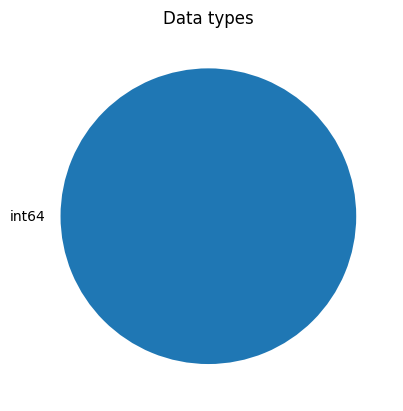

In [35]:
plot_dataframe_structure(df)

### Dataframe statistics

In [36]:
display(df.describe().T)

count           mean           std      min      25%       50%       75%  \
Ads  212.0  122354.716981  27368.707114  70335.0  98717.5  123830.0  146962.5   

          max  
Ads  169900.0

## Correlation & Autocorellation

In [37]:
plot_correlation(df)

No correlation for univariate time series


In [38]:
plot_acf_pacf(df, column=df.columns.to_list())

interactive(children=(Dropdown(description='column', options=('Ads',), value='Ads'), Output()), _dom_classes=(…

## Seasonal decomposition

### Seasonal decomposition with one period

In [39]:
plot_seasonal_decompose(df, column=df.columns.to_list(), model=['additive', 'multiplicative'], period=(1,int(df.shape[0]/4),1))

interactive(children=(Dropdown(description='column', options=('Ads',), value='Ads'), Dropdown(description='mod…

### Seasonal decomposition with two periods

In [40]:
plot_seasonal_decompose_2(df, column=df.columns.to_list(), period1=(1,int(df.shape[0]/4),1), period2=(1,20,1))

interactive(children=(Dropdown(description='column', options=('Ads',), value='Ads'), IntSlider(value=27, descr…

## Unobserved components decomposition

In [41]:
plot_unobserved_components(df, column=df.columns.to_list(), model=model_uc, method=method, confidence=(0.8,1,0.01))

interactive(children=(Dropdown(description='column', options=('Ads',), value='Ads'), Dropdown(description='mod…

# Convert time series to supervised learning problem 

In [42]:
df_copy = df.copy()

In [43]:
df_s, target_col_ts, preds = ts_dataframe_to_supervised(df_copy, target=target_col, n_in=lag_number, n_out=0, dropT=True)

## Quick EDA 

Correlation matrix


Hierarchical clustering


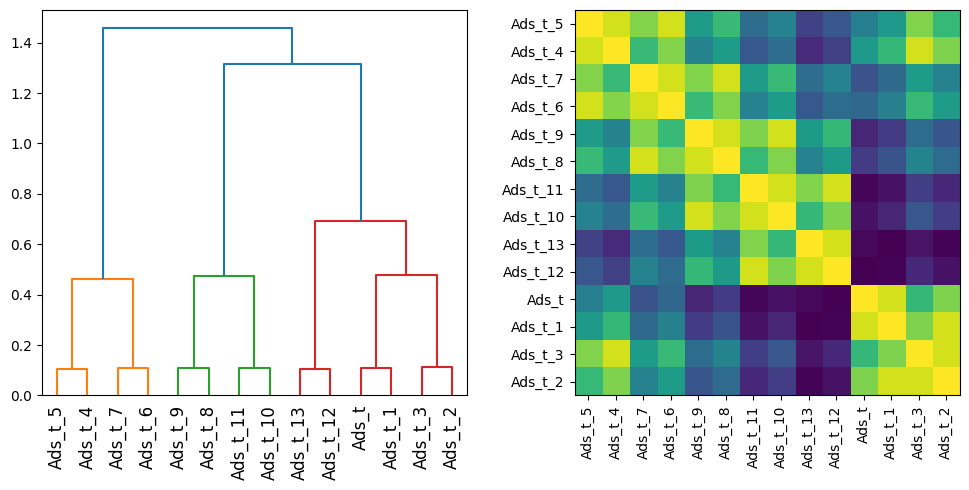

In [44]:
plot_correlation(df_s)

In [45]:
encoding(df_s, threshold_cat, target_col_ts);

Encoding numeric column: Ads_t
Encoding numeric column: Ads_t_13
Encoding numeric column: Ads_t_12
Encoding numeric column: Ads_t_11
Encoding numeric column: Ads_t_10
Encoding numeric column: Ads_t_9
Encoding numeric column: Ads_t_8
Encoding numeric column: Ads_t_7
Encoding numeric column: Ads_t_6
Encoding numeric column: Ads_t_5
Encoding numeric column: Ads_t_4
Encoding numeric column: Ads_t_3
Encoding numeric column: Ads_t_2
Encoding numeric column: Ads_t_1


## Splitting dataframe in features and targets

In [46]:
y = df_s[target_col_ts]

In [47]:
X = df_s.drop(target_col_ts, axis=1)

## Dimensions

In [48]:
nb_features = len(X.columns.tolist())

In [49]:
nb_targets = 1

In [50]:
layer_size = nb_features + nb_targets + 2

## Splitting data in train and test sets 

In [51]:
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size)

# Modeling

## Model building

### Pipeline building

#### Select the categorical and numerical columns

In [52]:
cat_selector = make_column_selector(dtype_include=object)

In [53]:
num_selector = make_column_selector(dtype_include=np.number)

#### For models based on tree

In [54]:
cat_tree_processor = make_pipeline(SimpleImputer(strategy='most_frequent'), OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))

In [55]:
num_tree_processor = make_pipeline(IterativeImputer(random_state=random_state, add_indicator=True))

In [56]:
tree_preprocessor = make_column_transformer((num_tree_processor, num_selector), (cat_tree_processor, cat_selector))

#### For models not based on tree

In [57]:
cat_ntree_processor = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown='ignore', sparse_output=False))

In [58]:
num_ntree_processor = make_pipeline(IterativeImputer(random_state=random_state, add_indicator=True), StandardScaler())

In [59]:
ntree_preprocessor = make_column_transformer((num_ntree_processor, num_selector), (cat_ntree_processor, cat_selector))

#### Level-0 models

In [65]:
level_0 = [ 
          ('GPRL', make_pipeline(ntree_preprocessor, GaussianProcessRegressor(kernel = ConstantKernel() * DotProduct() + ConstantKernel() + WhiteKernel(), random_state = random_state))), 
          ('GPRR', make_pipeline(ntree_preprocessor, GaussianProcessRegressor(kernel = ConstantKernel() * RBF() + ConstantKernel() + WhiteKernel(), random_state = random_state))), 
          ('GPRQ', make_pipeline(ntree_preprocessor, GaussianProcessRegressor(kernel = ConstantKernel() * RationalQuadratic() + ConstantKernel() + WhiteKernel(), random_state = random_state))), 
          ('DTRF', make_pipeline(tree_preprocessor, DecisionTreeRegressor(criterion='friedman_mse', random_state = random_state))), 
          ('DTRA', make_pipeline(tree_preprocessor, DecisionTreeRegressor(criterion='absolute_error', random_state = random_state))), 
#          ('DTRP', make_pipeline(tree_preprocessor, DecisionTreeRegressor(criterion='poisson', random_state = random_state))), 
          ('RFRS', make_pipeline(tree_preprocessor, RandomForestRegressor(criterion='squared_error', n_estimators=100, random_state = random_state))), 
          ('RFRA', make_pipeline(tree_preprocessor, RandomForestRegressor(criterion='absolute_error', n_estimators=100, random_state = random_state))), 
#          ('RFRP', make_pipeline(tree_preprocessor, RandomForestRegressor(criterion='poisson', n_estimators=100, random_state = random_state))), 
          ('HGBR', make_pipeline(tree_preprocessor, HistGradientBoostingRegressor(early_stopping=True, random_state = random_state))), 
          ('ELNE', make_pipeline(ntree_preprocessor, ElasticNet(alpha=0.01, l1_ratio=0.15, random_state = random_state))), 
          ('ELNECV', make_pipeline(ntree_preprocessor, ElasticNetCV(cv=5, random_state = random_state))), 
          ('LINR', make_pipeline(ntree_preprocessor, LinearRegression())), 
          ('KNRU', make_pipeline(ntree_preprocessor, KNeighborsRegressor(weights='uniform'))), 
          ('KNRD', make_pipeline(ntree_preprocessor, KNeighborsRegressor(weights='distance'))), 
          ('SVRL', make_pipeline(ntree_preprocessor, SVR(kernel='linear'))), 
          ('SVRP', make_pipeline(ntree_preprocessor, SVR(kernel='poly'))), 
          ('SVRG', make_pipeline(ntree_preprocessor, SVR(kernel='rbf'))), 
          ]

#### Level-1 model

In [66]:
level_1 = LinearRegression()

#### Stacking for regression

In [67]:
model = StackingRegressor(level_0, final_estimator=level_1, n_jobs=-1)

# Model fitting

In [68]:
%%time 
set_config(display='diagram') 
model.fit(X_train, y_train)

/home/fifi/anaconda3/envs/ezstacking/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/fifi/anaconda3/envs/ezstacking/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/fifi/anaconda3/envs/ezstacking/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/

CPU times: user 430 ms, sys: 155 ms, total: 585 ms
Wall time: 13.6 s


StackingRegressor(estimators=[('GPRL',
                               Pipeline(steps=[('columntransformer',
                                                ColumnTransformer(transformers=[('pipeline-1',
                                                                                 Pipeline(steps=[('iterativeimputer',
                                                                                                  IterativeImputer(add_indicator=True,
                                                                                                                   random_state=42)),
                                                                                                 ('standardscaler',
                                                                                                  StandardScaler())]),
                                                                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f151c58b5b0>),
                                                                                ('pipeline-2',
                                                                                 Pipel...
                                                                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f151c58b5b0>),
                                                                                ('pipeline-2',
                                                                                 Pipeline(steps=[('simpleimputer',
                                                                                                  SimpleImputer(strategy='most_frequent')),
                                                                                                 ('onehotencoder',
                                                                                                  OneHotEncoder(handle_unknown='ignore',
                                                                                                                sparse_output=False))]),
                                                                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f151c58aef0>)])),
                                               ('svr', SVR())]))],
                  final_estimator=LinearRegression(), n_jobs=-1)

# Model evaluation

### Model scoring

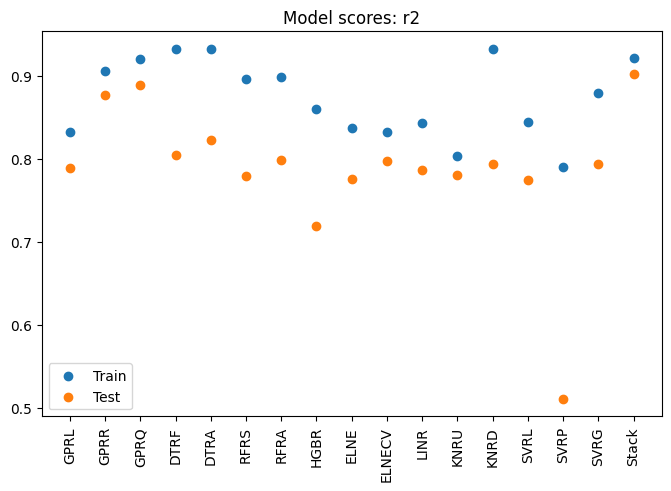

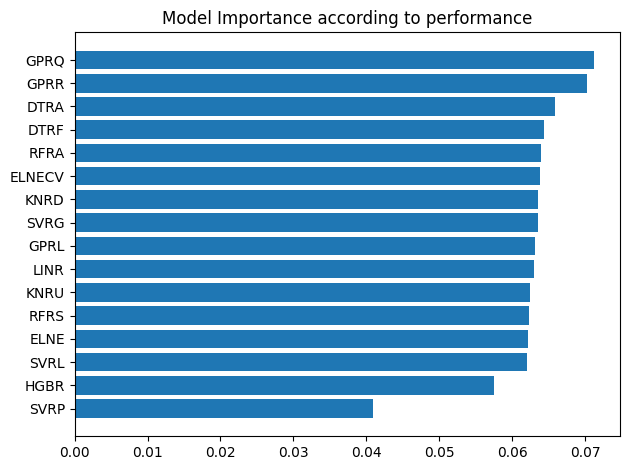

In [69]:
score_stack_0, mod_imp_score_0 = score_stacking(model, X_train, y_train, X_test, y_test)

### MAPE score

In [70]:
K_mape(model,X_train, y_train, X_test, y_test)

### Time series evaluation

In [71]:
plot_ts_results(X_train, y_train, X_test, y_test, model=model, confidence=(0.8,1,0.01), plot_intervals=True, plot_anomalies=False)

interactive(children=(FloatSlider(value=0.89, description='confidence', max=1.0, min=0.8, step=0.01), Checkbox…

# Model inspection

### Model importance

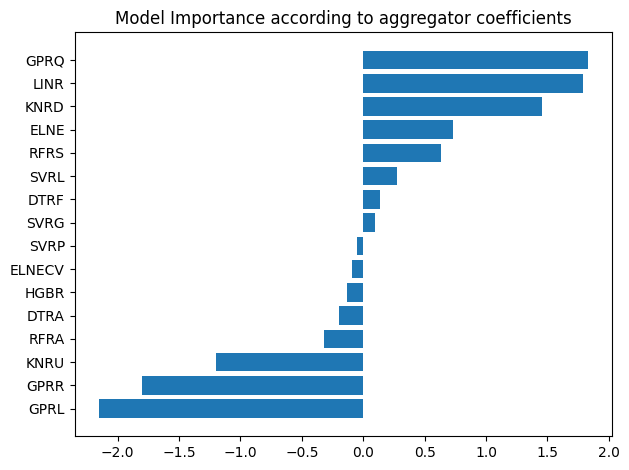

In [72]:
model_imp_0 = plot_model_importance(model, level_1_model)

### Feature permutation importance

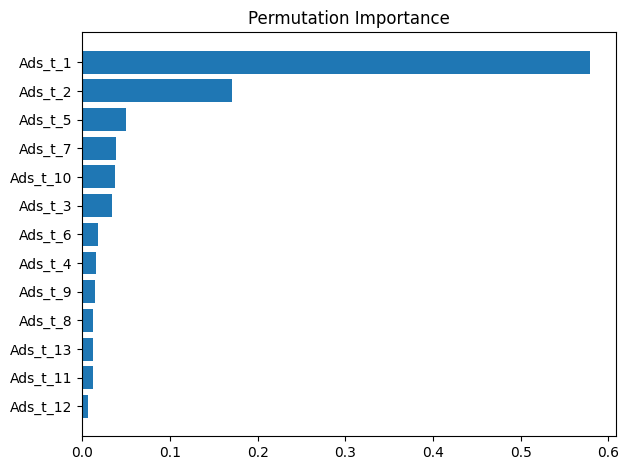

In [73]:
feature_importance_0 = plot_perm_importance(model, X_test, y_test, CPU)

# Level-0 model elimination

#### Filtered Level-0 models

In [74]:
level_0_f = model_filtering(level_0, model_imp_0, threshold_model, score_stack_0, threshold_score)

#### Level-1 model with filtration

In [75]:
level_1 = LinearRegression()

#### Build filtered model

In [76]:
model = StackingRegressor(level_0_f, final_estimator=level_1, n_jobs=-1)

# Filtered Model fitting

In [77]:
%%time 
set_config(display='diagram') 
model.fit(X_train, y_train)

/home/fifi/anaconda3/envs/ezstacking/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/fifi/anaconda3/envs/ezstacking/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/fifi/anaconda3/envs/ezstacking/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/

CPU times: user 140 ms, sys: 8.05 ms, total: 148 ms
Wall time: 3.03 s


StackingRegressor(estimators=[('GPRQ',
                               Pipeline(steps=[('columntransformer',
                                                ColumnTransformer(transformers=[('pipeline-1',
                                                                                 Pipeline(steps=[('iterativeimputer',
                                                                                                  IterativeImputer(add_indicator=True,
                                                                                                                   random_state=42)),
                                                                                                 ('standardscaler',
                                                                                                  StandardScaler())]),
                                                                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f151c58b5b0>),
                                                                                ('pipeline-2',
                                                                                 Pipel...
                                                                                 Pipeline(steps=[('simpleimputer',
                                                                                                  SimpleImputer(strategy='most_frequent')),
                                                                                                 ('onehotencoder',
                                                                                                  OneHotEncoder(handle_unknown='ignore',
                                                                                                                sparse_output=False))]),
                                                                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f151c58aef0>)])),
                                               ('kneighborsregressor',
                                                KNeighborsRegressor(weights='distance'))]))],
                  final_estimator=LinearRegression(), n_jobs=-1)

# Filtered Model evaluation

### Filtered Model scoring

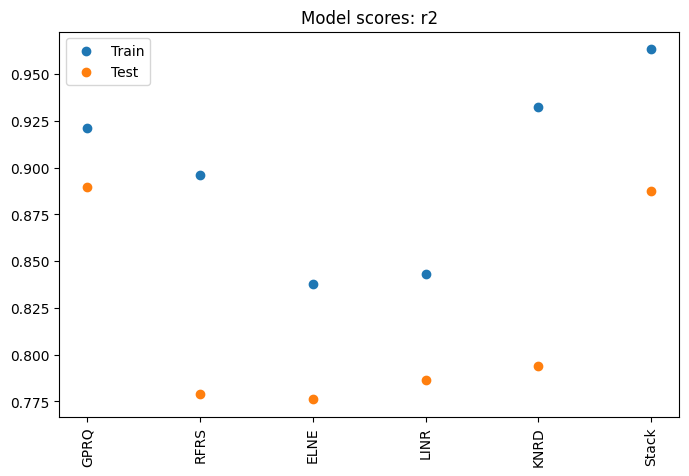

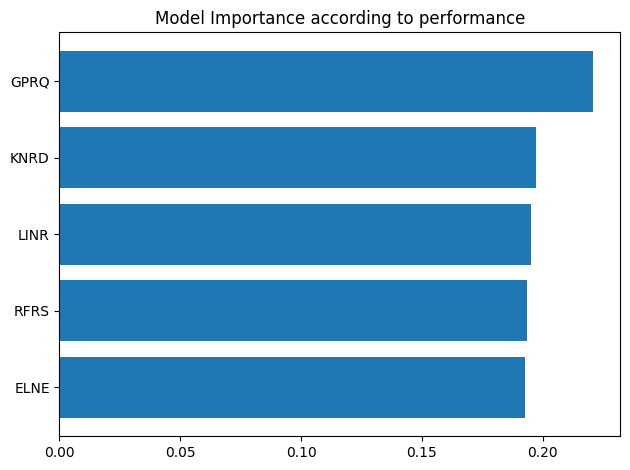

In [78]:
score_stack_1, mod_imp_score_1 = score_stacking(model, X_train, y_train, X_test, y_test)

### Filtered mape score

In [79]:
K_mape(model,X_train, y_train, X_test, y_test)

### Filtered Time series evaluation

In [80]:
plot_ts_results(X_train, y_train, X_test, y_test, model=model, confidence=(0.8,1,0.01), plot_intervals=True, plot_anomalies=False)

interactive(children=(FloatSlider(value=0.89, description='confidence', max=1.0, min=0.8, step=0.01), Checkbox…

# Filtered Model inspection

### Filtered Model importance

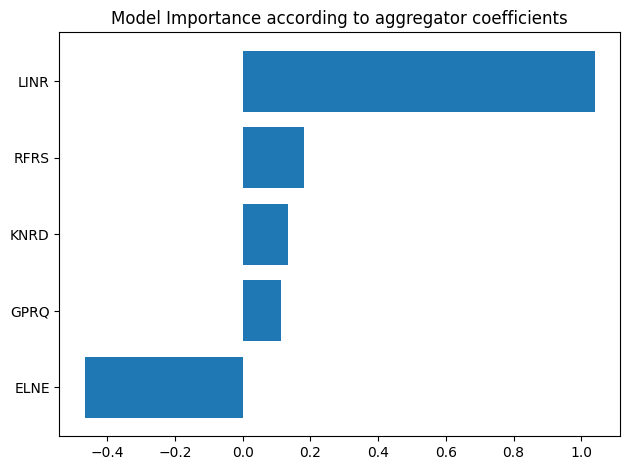

In [81]:
model_imp_1 = plot_model_importance(model, level_1_model)

### Filtered feature permutation importance

In [82]:
feature_importance_1 = plot_perm_importance(model, X_test, y_test, CPU)

#### Filtered feature elimination

In [83]:
best_feature, worst_feature = feature_filtering(feature_importance_1, threshold_feature)

In [84]:
dropped_cols = np.unique(np.concatenate((dropped_cols, worst_feature))).tolist()

### Check those columns, they should be dropped

In [85]:
print(dropped_cols)

['Ads_t_10', 'Ads_t_11', 'Ads_t_12', 'Ads_t_13', 'Ads_t_3', 'Ads_t_7', 'Ads_t_8', 'Ads_t_9']


# Final Model

In [86]:
df_copy = df.copy() 

In [87]:
df_s, target_col_ts, preds = ts_dataframe_to_supervised(df_copy, target=target_col, n_in=lag_number, n_out=0, dropT=True) 

In [88]:
df_s = df_s.drop(dropped_cols, axis=1, errors='ignore')

In [89]:
reduce_schema('column_name', dropped_cols)

## Quick EDA 

Correlation matrix


Hierarchical clustering


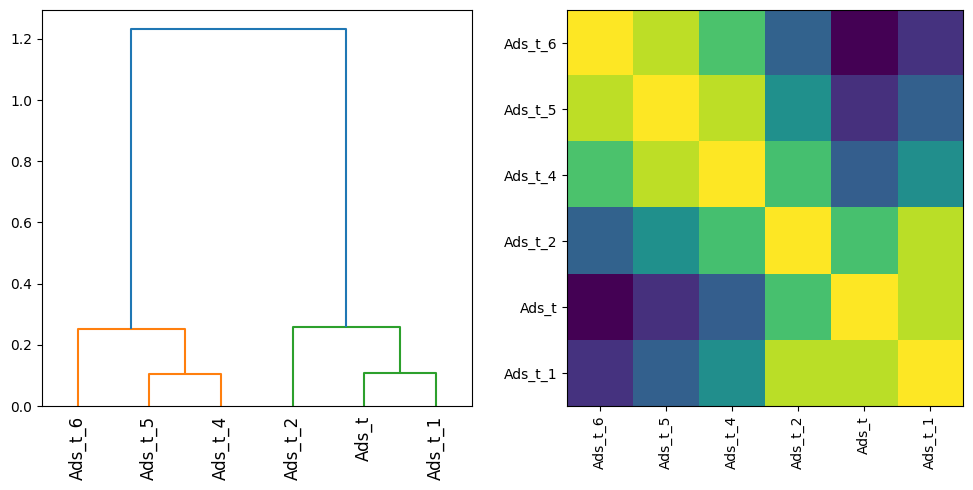

In [90]:
plot_correlation(df_s) 

In [91]:
y = df_s[target_col_ts] 

In [92]:
X = df_s.drop(target_col_ts, axis=1) 

## Dimensions

In [93]:
nb_features = len(X.columns.tolist()) 

In [94]:
nb_targets = 1 

In [95]:
layer_size = nb_features + nb_targets + 2 

## Splitting data in train and test sets 

In [96]:
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size) 

In [97]:
threshold_score = 0.7

#### Build final model

In [98]:
model = StackingRegressor(level_0_f, final_estimator=level_1, n_jobs=-1)

# Final Model fitting

In [99]:
%%time 
set_config(display='diagram') 
model.fit(X_train, y_train)

/home/fifi/anaconda3/envs/ezstacking/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/fifi/anaconda3/envs/ezstacking/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/fifi/anaconda3/envs/ezstacking/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnin

CPU times: user 149 ms, sys: 3.55 ms, total: 152 ms
Wall time: 2.49 s


StackingRegressor(estimators=[('GPRQ',
                               Pipeline(steps=[('columntransformer',
                                                ColumnTransformer(transformers=[('pipeline-1',
                                                                                 Pipeline(steps=[('iterativeimputer',
                                                                                                  IterativeImputer(add_indicator=True,
                                                                                                                   random_state=42)),
                                                                                                 ('standardscaler',
                                                                                                  StandardScaler())]),
                                                                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f151c58b5b0>),
                                                                                ('pipeline-2',
                                                                                 Pipel...
                                                                                 Pipeline(steps=[('simpleimputer',
                                                                                                  SimpleImputer(strategy='most_frequent')),
                                                                                                 ('onehotencoder',
                                                                                                  OneHotEncoder(handle_unknown='ignore',
                                                                                                                sparse_output=False))]),
                                                                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f151c58aef0>)])),
                                               ('kneighborsregressor',
                                                KNeighborsRegressor(weights='distance'))]))],
                  final_estimator=LinearRegression(), n_jobs=-1)

# Final Model evaluation

### Final Model scoring

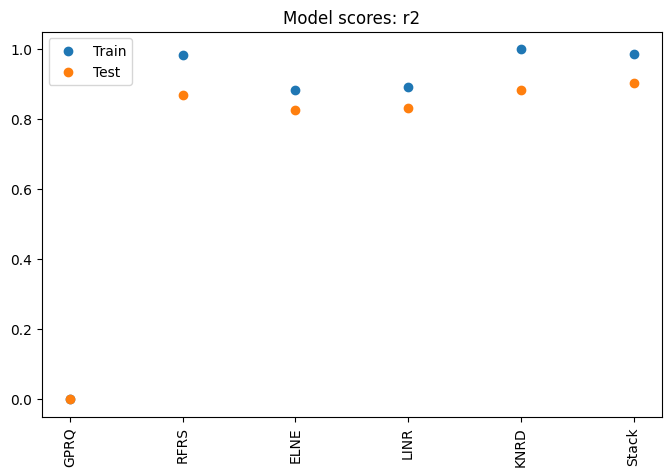

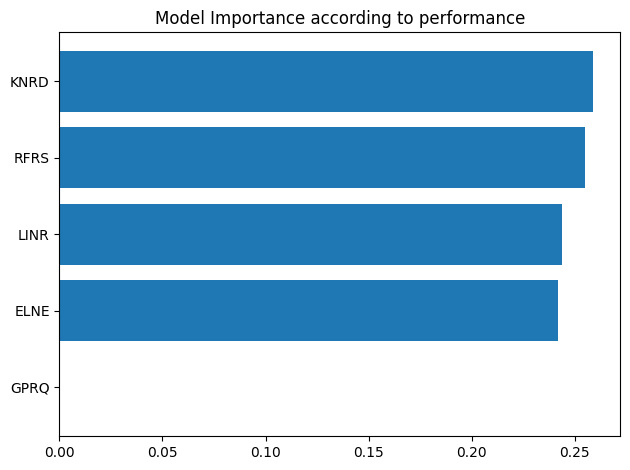

In [100]:
score_stack_2, mod_imp_score_2 = score_stacking(model, X_train, y_train, X_test, y_test)

### Final feature permutation importance

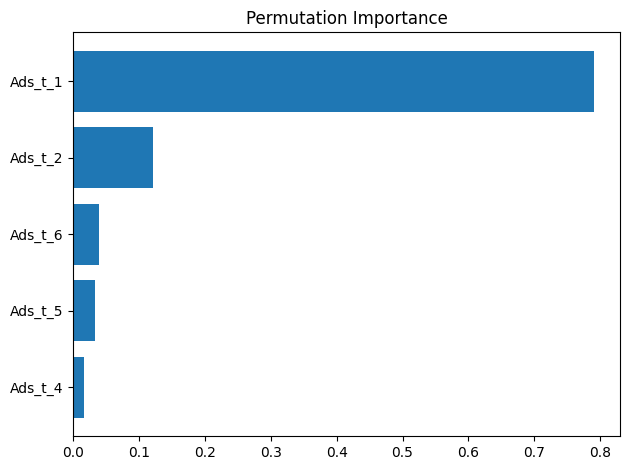

In [101]:
feature_importance_2 = feature_importance = plot_perm_importance(model, X_test, y_test, CPU)

#### Final feature elimination

In [102]:
best_feature, worst_feature = feature_filtering(feature_importance_2, threshold_feature)

### Final MAPE score

In [103]:
K_mape(model,X_train, y_train, X_test, y_test)

### Final Time series evaluation

In [104]:
plot_ts_results(X_train, y_train, X_test, y_test, model=model, confidence=(0.8,1,0.01), plot_intervals=True, plot_anomalies=False)

interactive(children=(FloatSlider(value=0.89, description='confidence', max=1.0, min=0.8, step=0.01), Checkbox…

# Final Model inspection

### Final Model importance

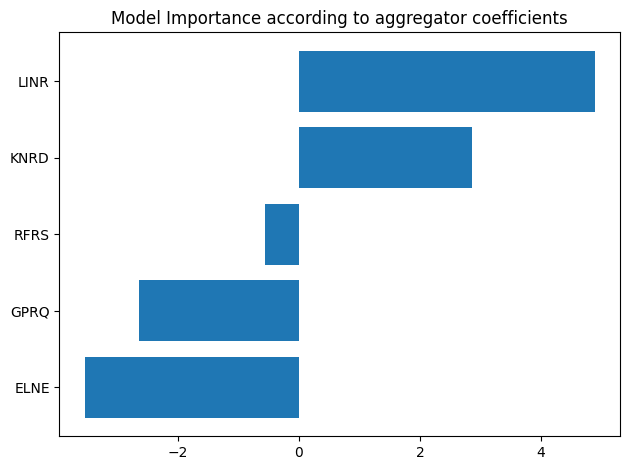

In [105]:
model_imp_2 = plot_model_importance(model, level_1_model)

### Final Feature permutation importance

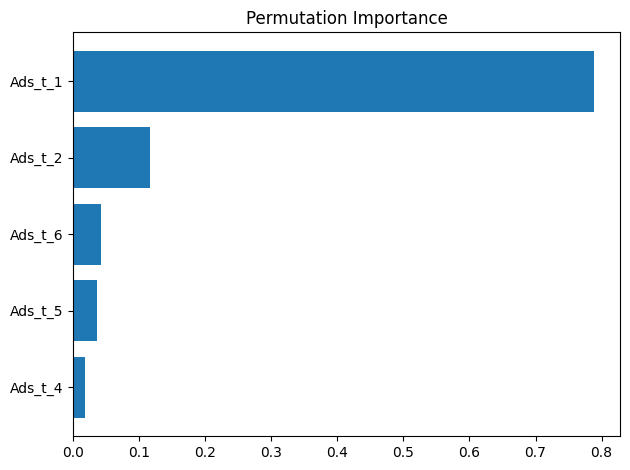

array([['Ads_t_4', 0.017582408619624724],
       ['Ads_t_5', 0.03607171606014391],
       ['Ads_t_6', 0.04140850579232025],
       ['Ads_t_2', 0.11638396733642875],
       ['Ads_t_1', 0.7885534021914824]], dtype=object)

In [106]:
plot_perm_importance(model, X_test, y_test, CPU)

### Final Partial Dependence & Individual Conditional Expectation 

In [107]:
pd_ice_plot(model=model, X=X_test, feature=X_test.columns.tolist(), CPU=CPU)

interactive(children=(Dropdown(description='feature', options=('Ads_t_6', 'Ads_t_5', 'Ads_t_4', 'Ads_t_2', 'Ad…

# Deployment

## Save your model

In [108]:
model_name = 'model.sav' 
dump(model, model_name)

['model.sav']

## Generate your server

In [109]:
fastapi_server(model, 'model.sav', X, y, FastAPI_port, with_keras)

## [Test your API](./server.ipynb)

## Docker

In [110]:
dockerize(name, model, model_name, X, y, Docker_port, with_keras)